In [1]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

On se place dans un marché comportant un actif risqué dont le prix est modélisé par le processus $S_t$, et un actif non risqué modélisé par $D_t$. Ces processus vérifient les équations suivantes : 

$ \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad dS_t = \mu S_tdt + \sigma S_t dB_t$ et $S_t=S_0 e^ \left( \left(\mu - \sigma^2/2 \right)t + \sigma B_t\right)$
$ \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad dD_t = rD_tdt \qquad \quad \; \;$ et $D_t=e^{rt}$

On va étudier le prix d'un call européen classique dont le sous-jacent est l'actif risqué $S_t$, en fonction des constantes suivantes : 
 - Le taux d'intérêt                 : $r$
 - La volatilité                     : $\sigma$
 - L'échéance du call                : $T$
 - Le strike                         : $K$
 - Le prix de l'actif risqué à $t=0$ : $S_0$
 
On effectue un changement de mesure de probabilité pour que le prix actualisé de l'actif et du call soit une martingale. On obtient la dynamique suivante : 
$ \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad dS_t = rS_tdt + \sigma S_t dB_t^Q$ et $S_t=S_0 e^ \left( \left(r - \sigma^2/2 \right)t + \sigma B_t^Q\right)$

## Black Scholes Formula
$$
C=N(  d_ {1}  )  S_ {t}  -N(  d_ {2}  )  Ke^ {-r(T-t)}  
$$

$$
d_ {1}  =  \frac {\ln \frac {S_ {t}}{K}+(r+\frac {\sigma ^ {2}}{2})(T-t)}{\sigma \sqrt {T-t}} 
$$

$$
d_ {2}  =  d_ {1}  -  \sigma \sqrt {T-t}  
$$ 


In [2]:
####################################################################################################################
################################### VARIABLES GLOBALES UTILISEES POUR CETTE QUESTION ####################################
####################################################################################################################
t = 0
K = 100
T= 1
sigma = 0.20
r = 0.05

### 1.1 Implémentation de la formule de Black-Scholes

In [3]:
## Calcule le prix du call européen à la date t lorsque le sous-jaçent vaut S_t à l'aide de la formule de Black-Scholes.
    
def Price_BS(S,K,t,T,r,sigma): 
    d1 = (np.log(S/K)+(r+sigma**2/2.)*(T-t))/(sigma*np.sqrt(T-t)) 
    
    d2 = d1-sigma*np.sqrt(T-t)
    return S*norm.cdf(d1)-K*np.exp(-r*(T-t))*norm.cdf(d2)

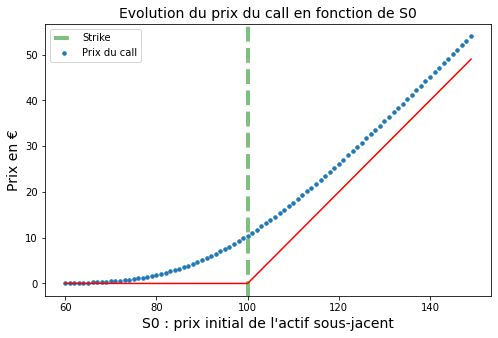

In [4]:
S0 = [K+i for i in range(-40,50)]
C = [Price_BS(S,K,t,T,r,sigma) for S in S0]

## figure
plt.figure(figsize=(8,5))
plt.axvline(x=K, ymin=0, ymax=1, color='green', alpha=0.5, linestyle='--', linewidth=4, label='Strike')
dr = [0 if i<K else i-K for i in S0]
plt.plot(S0,dr,color="red")
plt.scatter(S0, C,label='Prix du call',s=12)
plt.ylabel('Prix en €',fontsize=14)
plt.xlabel("S0 : prix initial de l'actif sous-jacent",fontsize=14)
plt.title("Evolution du prix du call en fonction de S0",fontsize=14)
plt.legend()

##### Commentaire
Lorsque $S_0 \ll K$, l'option a très peu de chances d'être exercée, et donc son prix est presque nul. Augmenter $S_0$ n'a alors que peu d'influence. Lorsque $S_0 = 80$, le prix de l'option devienne non négligeable et augmente de manière convexe jusqu'à ce que vers $S_0 = 100$, l'augmentation soit linéaire avec une pente de $1$. Cela représente le seuil à partir duquel l'option a de très fortes chances d'être exercée, donc l'option réplique la performance du sous-jaçent : elle augmente d'1€ s'il augmente d'1€ et vis versa, d'ou une pente de 1.

### 1.2 Implémentation de la méthode de Monte-Carlo pour calculer le prix d'un call européen

In [5]:
## monte carlo 
def Price_MC(S,K,t,T,r,sigma,n_sim):
    alpha = 0.95
    X = np.sqrt(T)*np.random.normal(0, 1, n_sim) ## nsim = 10000 à changer
    ST = S*np.exp((r - 0.5*sigma**2)*T + sigma*X)
    payoff = np.exp(-r*T)*np.maximum(ST-K,0)
    
    price = np.cumsum(payoff) / np.array([(i+1) for i in range(n_sim)])
    
    ## calcul de std
    variance=[0]
    d = 0
    m = payoff[0]
    for i in range(1,n_sim):
        delta = payoff[i]-m
        m=m+delta/(i+1)
        d=d+(i/(i+1))*delta**2
        variance.append(d/i)
    
    ## Confidence interval
    q_alpha = norm.ppf(1 - (1-alpha)/2)
    borne = q_alpha*np.sqrt(variance / np.array([(i+1) for i in range(n_sim)]))   
    conf_min = price - borne
    conf_max = price + borne
    
    return price[1:],conf_min[1:],conf_max[1:],variance[1:]

### 1.2.1  la convergence de l’estimateur Monte Carlo vers le prix exact, avec intervalles de confiance

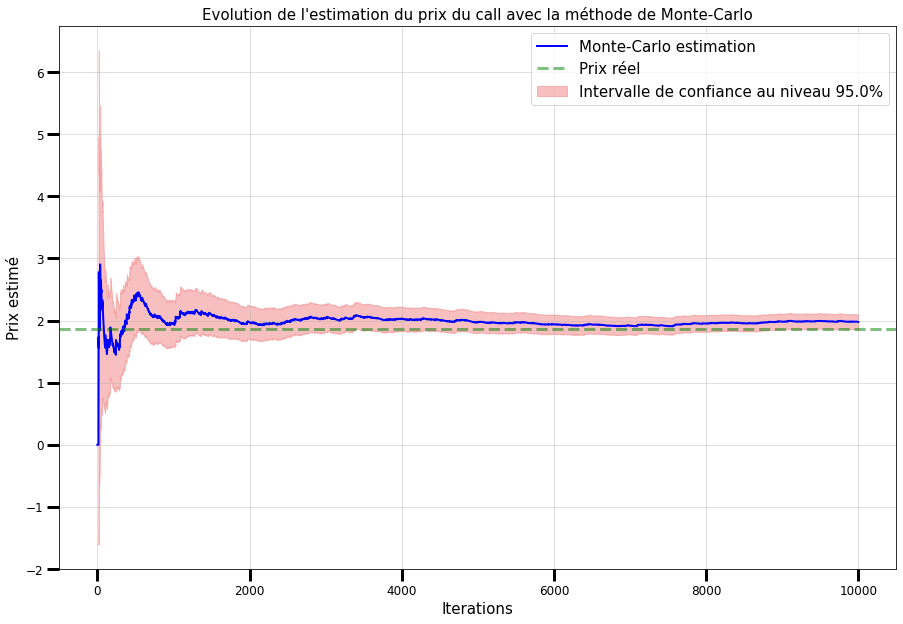

In [6]:
S = 80
n_sim = 10000
price,conf_min,conf_max,variance = Price_MC(S,K,t,T,r,sigma,n_sim)
real_price = Price_BS(S,K,t,T,r,sigma) 
iterations = [i for i in range(1,n_sim)]

## figure
plt.figure(4,figsize=(15,10))
plt.plot(iterations, price, color="blue", label="Monte-Carlo estimation", linewidth = 2)
plt.axhline(y=real_price, xmin=0, xmax=1, color='green', alpha=0.5, linestyle='--', linewidth=3, label='Prix réel')
plt.fill_between(iterations, conf_min, conf_max, color="lightcoral", alpha=0.5, label="Intervalle de confiance au niveau " + str(0.95 * 100) + "%")
plt.title("Evolution de l'estimation du prix du call avec la méthode de Monte-Carlo", fontsize=15)
plt.legend(fontsize=15)
plt.grid()
axes = plt.gca()
axes.tick_params(direction='out', length=12, width=3, labelsize=8, grid_alpha=0.5)
axes.set_xlabel('Iterations', fontsize=15)
axes.set_ylabel('Prix estimé', fontsize=15)
for tickLabel in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tickLabel.set_fontsize(12)

#### Commentaire
On observe bien la convergence de l'estimateur de Monte-Carlo vers le prix réel obtenu à partir de la formule de Black-Scholes. Pour un petit nombre d'itérations, l'incertitude est très élevée. Néamoins, l'erreur diminue rapidement après quelques centaines  itérations. Ensuite, la largeur de l'intervalle de confiance diminue moins vite qu'au début. 

### 1.2.2  la vitesse de convergence de l’estimateur Monte Carlo

On a vu précédemment que la variance diminuait lorsqu'on augmentait $n$. On cherche maintenant à quantifier cela, et identifier la vitesse de convergence de l'écart-type de l'estimateur de Monte-Carlo. La vitesse attendue est $O(\sqrt{n})$ : l'écart-type doit être proportionelle à $\frac{1}{\sqrt{n}}$.

-0.49783311225799753


Text(1, -1, 'Pente calculée  = -0.5')

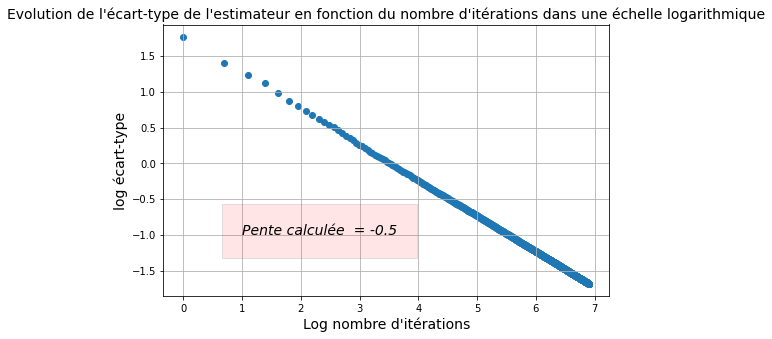

In [19]:
S = 80
n_sim = 1000

real_price = Price_BS(S,K,t,T,r,sigma)

var = []
pr=[]

## on moyenne les résultats sur plusieurs estimations afin de lisser les courbes 
for i in range(1000):
    
    price,conf_min,conf_max,variance = Price_MC(S,K,t,T,r,sigma,n_sim)
    var.append(variance)
    pr.append(price)

v = np.mean(np.array(var),axis=0)/ np.array(list(range(1,n_sim)))
ecart_type = np.sqrt(v)
iterations = [i for i in range(1,n_sim)]



slope, intercept = np.polyfit(np.log(iterations),np.log(ecart_type),1)
    

plt.figure(figsize=(8,5))
plt.scatter(np.log(iterations),np.log(ecart_type))
plt.ylabel('log écart-type',fontsize=14)
plt.xlabel("Log nombre d'itérations", fontsize=14)
plt.grid()
plt.title("Evolution de l'écart-type de l'estimateur en fonction du nombre d'itérations dans une échelle logarithmique", fontsize=14)

textstr = 'Pente calculée  = '+str(round(slope,1))

plt.text(1, -1, textstr, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.1, 'pad': 20},fontsize=14)

#### Commentaire 
Les résultats sont cohérents. le logarithme de l'écart-type de l'estimateur $C_n$ décroit linéairement avec le logarithme ddu nombre d'itérations. 

Cette évolution linéaire est de pente $-\frac{1}{2}$. En effet, si $\sigma_n = \frac{b}{\sqrt({n}}$ alors $log(\sigma_n) = log(b) - \frac{1}{2}log(n)$

### 1..2.3 Normalité de l'estimateur de Monte-Carlo

On s'intéresse à la distribution statistique des prix estimés par la méthode de Monte-Carlo. Elle dépend du nombre de scénarios simulés $n\_sim$. Pour cela, on lance 1000 fois l'algorithme de Monte-Carlo pour obtenir 1000 estimations du prix faites avec le meme $n\_sim$, on représente le tout dans un histogramme.

D'après le théorème central limite, on a :
$$
\sqrt{n}\left(\left(\frac{1}{n}\sum_{i=0}^n e^{-r(t-T)}(S_t + (S_T-S_t)^{(i)}-K)_+ \right) - C_t \right) \sim \mathcal{N}(0,\sigma(X)^2) \\
X = e^{-r(t-T)}(S_t + (S_T-S_t)-K)_+|S_t
$$
L'estimateur de Monte-Carlo suit donc une loi normale. Nous allons vérifier cela empiriquement, en vérifiant que l'histogramme se rapproche d'une loi normale centrée en le prix réel (calculé avec la formule de Black-Scholes).
La variance dépend de $n\_sim$, on effectue la simulation pour plusieurs valeurs de $n\_sim$.

Pour chaque histogramme, on calcule les paramètres $\mu$ et $\sigma$ de la loi normale qui approxime le mieux les données simulées. Pour mieux appréhender l'évolution de la variance, on trace ensuite sur un deuxième graphe toutes les loi normales estimées.

In [38]:
def MC_p(S,K,t,T,r,sigma,n_sim):
    
    ST = S*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*np.random.normal(0, 1, n_sim))
    
    payoff = np.exp(-r*T)*np.maximum(ST-K,0)
    
    return np.mean(payoff)

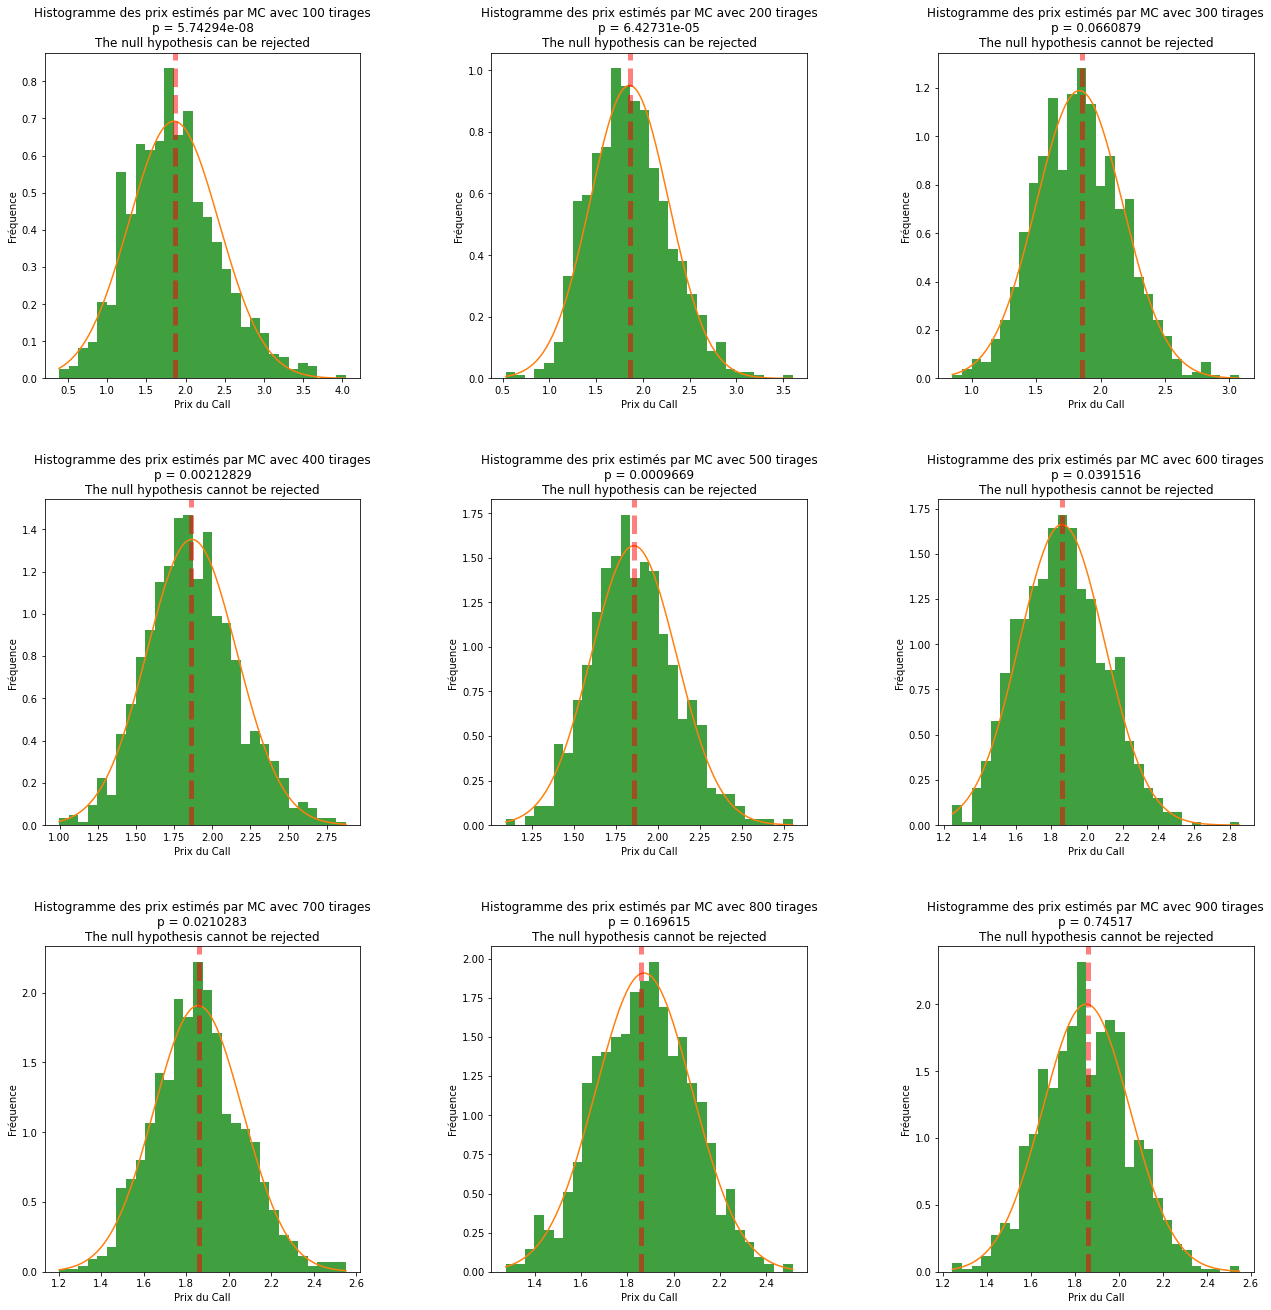

In [70]:
list_n_sim = [100*i for i in range(1,10)]

list_mu,list_sigma = [],[]

real_price = Price_BS(S,K,t,T,r,sigma)

fig1, axs = plt.subplots(3, 3,figsize=(20,20))
fig1.tight_layout(pad=10)
for i in range(len(list_n_sim)):
    
    p = [MC_p(S,K,t,T,r,sigma,list_n_sim[i]) for j in range(1000)]
    mu_est,sigma_est = np.mean(p),np.std(p)
    list_mu.append(mu_est)
    list_sigma.append(sigma_est)
    v,w = i//3,i%3
    n, bins, patches = axs[v,w].hist(p,30,density=True,histtype ='bar', facecolor='g', alpha=0.75)
    x = np.linspace(min(bins),max(bins),200)
    axs[v,w].plot(x,1/(sigma_est * np.sqrt(2 * np.pi)) *np.exp( - (x - mu_est)**2 / (2 * sigma_est**2)),label ="loi normal approximée")
    axs[v,w].axvline(x=real_price, ymin=0, ymax=1, color='red', alpha=0.5, linestyle='--', linewidth=5, label='Prix réel du call')
    axs[v,w].set_xlabel('Prix du Call')
    axs[v,w].set_ylabel('Fréquence')
    
    
    k2, p = stats.normaltest(p)
    alpha = 1e-3
    text = "p = {:g}".format(p) + '\n'
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        text += "The null hypothesis can be rejected"
    else:
        text += "The null hypothesis cannot be rejected"
        
    axs[v,w].set_title("Histogramme des prix estimés par MC avec " + str(list_n_sim[i]) + " tirages" + '\n'+text)

#### Commentaire
Pour chaque nombre de tirage on calcule la p-valeur correspondant au test statistique dont l'hypothèse nulle est "les prix sont distubués selon une loi normale". On constate que à partir de 300 tirages, la distribution des prix selon monte carlo réusissent le test statistique.

Comme attendu, les histogrammes ont une forme de cloche, et se rapprochent d'une loi normale centrée en le prix réel. 
0n observe ensuite que plus $n\_sim$ est grand, plus la variance est faible, ce qui est cohérent avec le théorème.

Remarque

quelques barres dépassent 1 ce qui est totalement normal. La règle est que toutes les aires de toutes les barres doivent totaliser un. Lorsque les barres sont très étroites, leur somme peut être assez grande bien que leurs aires totalisent un. La hauteur d'une barre multipliée par sa largeur est la probabilité qu'une valeur soit dans cette plage. Pour que la hauteur soit égale à la probabilité, il faut des barres de largeur un